# Encajes de Vecinos Estocásticos con distribución t

El método de PCA es muy usado debido a su popularidad y simpleza. Sin embargo, su principal desventaja es que se limita a una transformación lineal. Muchas veces, los datos con los que trabajamos son muy complejos y requieren transformaciones más complicadas para una visualización más útil. 

El algoritmo de t-SNE obtiene la distribución de los vecinos de los puntos originales y busca replicar esa distribución en un espacio de menor dimensión. La idea es que los puntos cercanos aparezcan cercanos en el espacio reducido (no le importan los puntos lejanos).

El algoritmo funciona de la siguiente manera. Para cada punto $x_i$, se centra una distribución gaussiana en ese punto. Luego, para cada $x_j$, se obtiene su densidad normalizada dada por dicha distribución. Esto es, la probabilidad condicional de elegir al punto $x_j$ dado el punto central $x_i$ es:

$$p_{j|i}= \frac{\exp(-||x_i-x_j||^2/2\sigma_i^2)}{\sum_{k\ne i}\exp(-||x_i-x_k||^2/2\sigma_i^2)}$$

La normalización garantiza que $\sum_j p_{j|i}=1$. La probabilidad condicional $p_{j|i}$ es la probabilidad de que el punto $x_i$ eliga al punto $x_j$ como su vecino tomando en cuenta la distribución gaussiana centrada en $x_i$. Se define la distribución 

$$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2N}$$

donde $N$ es la cantidad de puntos. Intuitivamente, $p_{ij}$ es la probabilidad de que los puntos $x_i, x_j$ sean vecinos. La desviación estandar $\sigma_i$ depende de un valor llamado **perplejidad** que se indica con el número de vecinos que se toman alrededor de cada punto. Este valor lo define el usuario.

Se busca elegir vectores reducidos de dimensión $y_i$ que tengan la misma distribución de $p_{ij}$. Se define 

$$q_{ij}=\frac{(1+||y_i-y_j||^2)^{-1}}{\sum_k\sum_{l\ne k}(1+||y_k-y_l||^2)^{-1}}$$

aquí se usa una distribución $t$-student en lugar de agussianas. Para medir la similitud entre $p_{ij}$ y $q_{ij}$ se usa **Kullback-Leibler** (KL) que se define como 

$$KL(P||Q)=\sum_{i\ne j}p_{ij}\log\frac{p_{ij}}{q_{ij}}$$

La minimización se hace usando la técnica del descenso de gradiente para obtener los puntos $y_i$.

El algoritmo es cuadrático en tiempo y espacio así que se recomienda no usarlo en muchos datos.

Veamos un ejemplo de uso del $t$-SNE con el conjunto de datos de MNIST.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

X = mnist.data
y = mnist.target.astype(np.uint8)

X.shape, y.shape

C:\Users\msubr\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


((70000, 784), (70000,))

Tenemos 70k ejemplos de 784 dimensiones cada uno. El método requiere el parámetro de las dimensiones de salida, vamos a usar `n_components=2`. Otro parámetro es la perplejidad. Vamos a iterar variando desde 5 hasta 50 la perplejidad en una muestra de 2k puntos. Vamos a graficar la métrica KL para elegir la perplejidad que tenga la KL más chica.

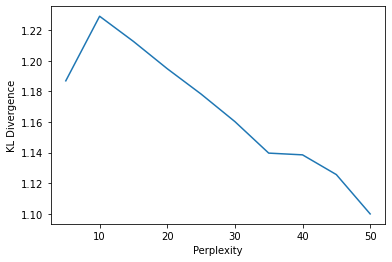

In [5]:
kl = []
for i in range(5, 55, 5):
    tsne = TSNE(n_components=2, perplexity=i)
    X_tsne = tsne.fit_transform(X[0:2000])
    kl.append(tsne.kl_divergence_)
plt.plot(range(5, 55, 5), kl)
plt.xlabel("Perplexity")
plt.ylabel("KL Divergence")
plt.show()

Elejimos la perplejidad de 50 para nuestro conjunto de datos. Note que usamos 10k elementos porque no queremos que tarde mucho la ejecución.

In [6]:
st = time.time()
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X[0:10000])
print("Tiempo total:", time.time() - st)

Tiempo total: 42.138206481933594


In [7]:
print("Tiene una KL de:", tsne.kl_divergence_)

Tiene una KL de: 1.6694427728652954


Graficamos los puntos proyectados en dos dimensiones.

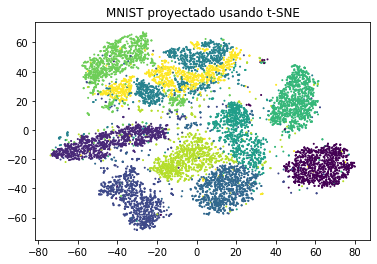

In [8]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[0:10000], s=1)
plt.title("MNIST proyectado usando t-SNE")
plt.show()

## Usando PCA + t-SNE

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X[0:10000])
X_pca.shape

(10000, 50)

In [10]:
st = time.time()
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X_pca)
print("Tiempo total:", time.time() - st)
print("Tiene una KL de:", tsne.kl_divergence_)

Tiempo total: 41.144171714782715


1.6148852109909058

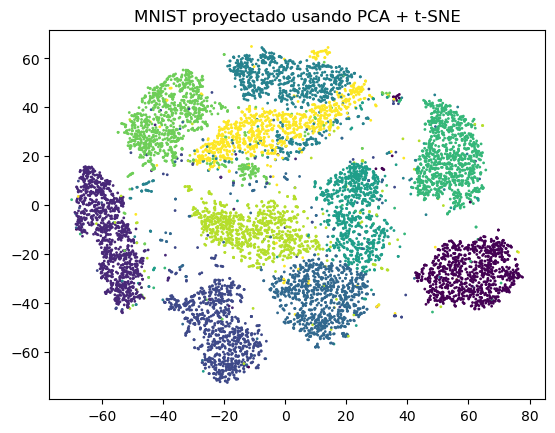

In [90]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[0:10000], s=1)
plt.title("MNIST proyectado usando PCA + t-SNE")
plt.show()